In [1]:
import sys

import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

sys.path.insert(0, "../")

%load_ext autoreload
%autoreload 2

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import src
from src.datasets.coco_eft import COCO_EFT
from src.datasets.h36m import Human36M
from src.datasets.datasets_common import UNNORMALIZE
from src.datasets.threedpw import ThreeDPW
from src.datasets.pennaction import PennAction
from src.functional import smpl
from src.utils import img_utils, vis_utils, video_utils
import numpy as np
import cv2 


from src.utils.img_utils import perspective_projection

import pickle as pkl

import cv2
import os

In [3]:
from src.functional.hmr import hmr_inference
from src.models.hmr import get_hmr
def get_hmr_pretrained(ckpt_path):
    ### load hmrnet
    hmrnet = get_hmr(pretrained=True)
    ckpt = torch.load(ckpt_path, map_location="cpu")
    hmrnet.load_state_dict(ckpt["hmrnet_state_dict"])
    hmrnet.eval();
    return hmrnet

# init OF model

In [4]:
device = "cuda:0"

from src.models import raft
optical_flow_model = raft.get_raft_pretrained()
optical_flow_model.eval()
optical_flow_model = optical_flow_model.to(device)

from src.functional.optical_flow import unproject_optical_flows_to_vertices, get_of

In [5]:
from src.functional import smpl
from src.functional.renderer import unproject_to_vertices, fit_vertices_to_orthographic

smpl_model = smpl.get_smpl_model("extra", device=device)
faces = smpl_model.faces.astype(int)
smpl_model_faces = torch.tensor(faces.copy()).unsqueeze(0)

In [6]:
def of_run(img1, img2, device, max_batch=32):
    
    if img1.size(0) > max_batch:
        img1 = torch.split(img1, max_batch)
        img2 = torch.split(img2, max_batch)
        of_f, of_b = [], []
        for img1_, img2_ in zip(img1, img2):
            of_f_, of_b_ = of_run(img1_, img2_, device)
            of_f.append(of_f_)
            of_b.append(of_b_)
        of_f = torch.cat(of_f)
        of_b = torch.cat(of_b)
        return of_f, of_b
    
    img1 = img1.to(device)
    img2 = img2.to(device)
    
    with torch.no_grad():
        # compute forward optical flow
        _, of_f = optical_flow_model(img1, img2, iters=20, test_mode=True)
        # compute backward optical flow
        _, of_b = optical_flow_model(img2, img1, iters=20, test_mode=True)
    
    of_f = of_f.cpu()
    of_b = of_b.cpu()
    del img1
    del img2
    torch.cuda.empty_cache()
    
    return of_f, of_b


# init HMR

In [7]:
# ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/output/train_hmr_fractional/train_hmr_frac__50/best.pth"
ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/coco-all.pt"
hmrnet = get_hmr_pretrained(ckpt)
hmrnet = hmrnet.to(device)

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/hub.py:704: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


In [8]:
dset_names = ["h36m", "3dpw", "pennaction"]

dset_3dpw = ThreeDPW(set="test", seqlen=8, debug=True, use_OFformat=True)
dset_h36m = Human36M(set="train", seqlen=8, debug=True, use_OFformat=True)
dset_pa = PennAction(seqlen=8, debug=True, use_OFformat=True)
dsets = [dset_h36m, dset_3dpw, dset_pa]

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 4307
Human36M Dataset overlap ratio:  0.0
Loaded h36m dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/h36m/h36m_train_25fps_db.pt
h36m - number of dataset objects 36592
Loaded pennaction dataset from /cvlabsrc1/cvlab/dataset_PennAction/Penn_Action/../pennaction_train_scale12_db.pt
pennaction - number of dataset objects 19465


In [24]:
# for dset_name in dset_names:
#     d[dset_name] = {}
#     for seqlen in [1,3,5,7]:
#         d[dset_name][seqlen] = {}
#         for res in ["LR", "HR"]:
#             d[dset_name][seqlen][res] = {}
#             d[dset_name][seqlen][res]["hmr"] = []
#             d[dset_name][seqlen][res]["gt"] = []
#             d[dset_name][seqlen][res]["of_on_hmr"] = []
#             d[dset_name][seqlen][res]["of_on_gt"] = []
#             d[dset_name][seqlen][res]["mask"] = []


# for dset_name in d:
#     for seqlen in [1,3,5,7]:
#         for res in ["LR","HR"]:
#             d_ = d[dset_name][seqlen][res]
#             for k in d_:
#                 d_[k] = torch.cat(d_[k], dim=0)
#                 d_[k] = d_[k].numpy()
#             np.save(f"./../paper_sub/ablation_OFquality/8.03/{dset_name}_{seqlen}_{res}.npy", d_)



In [32]:
# dset = dset_3dpw
# dset_name = "3dpw"

# dset = dset_h36m
# dset_name = "h36m"

dset = dset_pa
dset_name = "pennaction"

torch.manual_seed(0)
dataload = torch.utils.data.DataLoader(dset, batch_size=10, shuffle=True, num_workers=8)
        
for seqlen in [1,3,5,7]:        
    for res in ["LR", "HR"]:
        print(dset_name, seqlen, res)
        d = {}
        d["hmr"] = []
        d["gt"] = []
        d["of_on_hmr"] = []
        d["of_on_gt"] = []
        d["mask"] = []
        
        indices = [0, seqlen]
        torch.manual_seed(0)
        dataload = torch.utils.data.DataLoader(dset, batch_size=10, shuffle=True, num_workers=8)
        for batch_idx, sample in tqdm(enumerate(dataload), total=len(dataload)):
            img_hmr = sample['video'][:, indices].clone()        

            if res == "LR":
                img = img_hmr.clone()
                img_size = 224
            elif res == "HR":
                img = sample['videoOF'][:, indices].clone()
                img_size = 640
            else:
                raise NotImplementedError
                
            batch_size = img.size(0)
            kp_2d_gt = sample["kp_2d"][:, indices].clone()
            kp_2d_gt[:,:,:2] = (kp_2d_gt[:,:,:2] + 1) / 2 * img_size

            ### HMR inference
            with torch.no_grad():
                out = hmr_inference(img_hmr.flatten(start_dim=0, end_dim=1).to(device), hmrnet, smpl_model, img_size=img_size)
            j3d = out["j3d"]
            j3d = j3d.view(batch_size, 2, j3d.size(-2), 3)

            ### OF inference
            of = get_of(optical_flow_model, UNNORMALIZE(img[:,0]), UNNORMALIZE(img[:,1]), device)

            ### get of on hmr
            j3d_orth__hmr = fit_vertices_to_orthographic(j3d[:,0].clone(), img_size=(img_size,img_size))

            ### get of on gt
            j3d__gt = kp_2d_gt.clone().to(device)
            j3d__gt[:,0,:,2] = j3d__gt[:,0,:,2].clone()
            j3d_orth__gt  = fit_vertices_to_orthographic(j3d__gt[:,0].clone(), img_size=(img_size,img_size))

            flow_hmr = j3d[:, 1, :, :2] - j3d[:, 0, :, :2]
            flow_gt = kp_2d_gt[:, 1, :, :2] - kp_2d_gt[:, 0, :, :2]
            flow_of_on_hmr = unproject_to_vertices(of, j3d_orth__hmr) # B x N x 2
            flow_of_on_gt = unproject_to_vertices(of, j3d_orth__gt) # B x N x 2
            mask = (kp_2d_gt[:,0,:,2] * kp_2d_gt[:,1,:,2]) > 0.

            d["hmr"].append(flow_hmr.cpu().numpy())
            d["gt"].append(flow_gt.cpu().numpy())
            d["of_on_hmr"].append(flow_of_on_hmr.cpu().numpy())
            d["of_on_gt"].append(flow_of_on_gt.cpu().numpy())
            d["mask"].append(mask.cpu().numpy())
        
            if batch_idx == 16:
                for k in d:
                    d[k] = np.concatenate(d[k], axis=0)
                np.save(f"./../paper_sub/ablation_OFquality/8.03/{dset_name}_{seqlen}_{res}.npy", d)
                break
#         break
#     break
            


pennaction 1 LR


  0%|                                                                                                                                                    | 0/1947 [00:00<?, ?it/s]/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
  1%|█▏                                                                                                                                         | 16/1947 [00:08<18:00,  1.79it/s]


pennaction 1 HR


  1%|█▏                                                                                                                                         | 16/1947 [00:11<23:35,  1.36it/s]


pennaction 3 LR


  1%|█▏                                                                                                                                         | 16/1947 [00:07<14:43,  2.19it/s]


pennaction 3 HR


  1%|█▏                                                                                                                                         | 16/1947 [00:14<29:24,  1.09it/s]


pennaction 5 LR


  1%|█▏                                                                                                                                         | 16/1947 [00:07<14:32,  2.21it/s]


pennaction 5 HR


  1%|█▏                                                                                                                                         | 16/1947 [00:12<24:51,  1.29it/s]


pennaction 7 LR


  1%|█▏                                                                                                                                         | 16/1947 [00:07<14:42,  2.19it/s]


pennaction 7 HR


  1%|█▏                                                                                                                                         | 16/1947 [00:11<23:55,  1.35it/s]


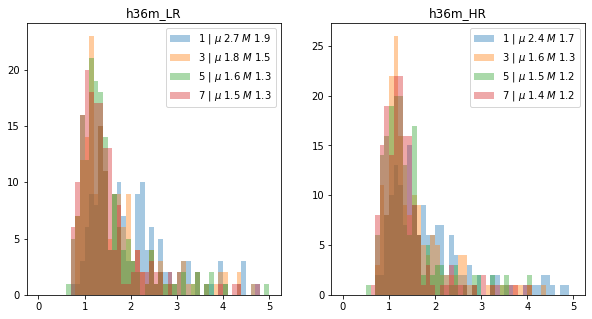

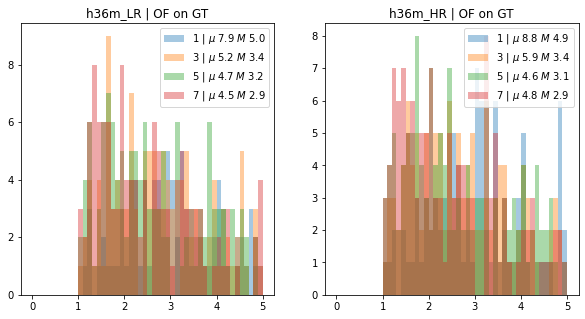

In [48]:
dset_name = 'h36m'

fig, ax = plt.subplots(1,2,figsize=(10,5))
for i, res in enumerate(["LR", "HR"]):
    for seqlen in [1,3,5,7]:
        d = np.load(f"./../paper_sub/ablation_OFquality/8.03/{dset_name}_{seqlen}_{res}.npy", allow_pickle=True).item()
        mask = d["mask"]
        hmr___gt = np.linalg.norm(d['hmr'] - d['gt'], axis=-1)
        hmr___gt = (hmr___gt * mask).sum(axis=-1) / mask.sum(axis=-1)

        of_hmr___gt = np.linalg.norm(d['of_on_hmr'] - d['gt'], axis=-1)
        of_hmr___gt = (of_hmr___gt * mask).sum(axis=-1) / mask.sum(axis=-1)

        ratios = hmr___gt / of_hmr___gt
        ax[i].hist(ratios, bins=50, range=(0,5), alpha=0.4, 
                label=f"{seqlen} | $\mu$ {ratios.mean():.1f} $M$ {np.median(ratios):.1f}")
    ax[i].set_title(f"{dset_name}_{res}")
    ax[i].legend()
    
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i, res in enumerate(["LR", "HR"]):
    for seqlen in [1,3,5,7]:
        d = np.load(f"./../paper_sub/ablation_OFquality/8.03/{dset_name}_{seqlen}_{res}.npy", allow_pickle=True).item()
        mask = d["mask"]
        hmr___gt = np.linalg.norm(d['hmr'] - d['gt'], axis=-1)
        hmr___gt = (hmr___gt * mask).sum(axis=-1) / mask.sum(axis=-1)

        of_gt___gt = np.linalg.norm(d['of_on_gt'] - d['gt'], axis=-1)
        of_gt___gt = (of_gt___gt * mask).sum(axis=-1) / mask.sum(axis=-1)

        ratios = hmr___gt / of_gt___gt
        ax[i].hist(ratios, bins=50, range=(0,5), alpha=0.4, 
                label=f"{seqlen} | $\mu$ {ratios.mean():.1f} $M$ {np.median(ratios):.1f}")
    ax[i].set_title(f"{dset_name}_{res} | OF on GT")
    ax[i].legend()
    
    

In [49]:
dset_3dpw = ThreeDPW(set="test", seqlen=300, debug=True, use_OFformat=True)

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 97


In [50]:
sample = dset_3dpw[0]

In [51]:
imgLR = sample['video']
imgHR = sample['videoOF']


In [54]:
j3d_arr = []
for imgLR_ in torch.split(imgLR, 16):
    with torch.no_grad():
        out = hmr_inference(imgLR_.to(device), hmrnet, smpl_model, img_size=img_size)
    j3d_ = out["j3d"]
    j3d_arr.append(j3d_)
j3d = torch.cat(j3d_arr, dim=0)

In [74]:
j3dLR = j3d

In [56]:
j3dHR = j3d/224 * 640

In [78]:
kp_2d_gt = sample["kp_2d"].clone()
kp_2d_gt[:,:,:2] = (kp_2d_gt[:,:,:2] + 1) / 2
kp_2d_gtLR = kp_2d_gt.clone() * 224
kp_2d_gtHR = kp_2d_gt.clone() * 640

In [73]:
ofLR = of_run(UNNORMALIZE(imgLR[:-1]), UNNORMALIZE(imgLR[1:]), device)[0]

In [71]:
ofHR = of_run(UNNORMALIZE(imgHR[:-1]).contiguous(), UNNORMALIZE(imgHR[1:]).contiguous(), device, max_batch=4)

In [87]:
ofHR = ofHR[0]

In [76]:
### get of on hmr
j3d_orth__hmrLR = fit_vertices_to_orthographic(j3dLR[:-1].clone(), img_size=(224,224))
j3d_orth__hmrHR = fit_vertices_to_orthographic(j3dHR[:-1].clone(), img_size=(640,640))

In [90]:
### get of on gt
j3d__gtLR = kp_2d_gtLR.clone().to(device)
j3d__gtLR[:-1,:,2] = j3d__gtLR[:-1,:,2].clone()
j3d_orth__gtLR  = fit_vertices_to_orthographic(j3d__gtLR[:-1].clone(), img_size=(224,224))

j3d__gtHR = kp_2d_gtHR.clone().to(device)
j3d__gtHR[:-1,:,2] = j3d__gtHR[:-1,:,2].clone()
j3d_orth__gtHR  = fit_vertices_to_orthographic(j3d__gtHR[:-1].clone(), img_size=(640,640))


In [91]:
flow_hmrLR = j3dLR[1:, :, :2] - j3dLR[:-1, :, :2]
flow_hmrHR = j3dHR[1:, :, :2] - j3dHR[:-1, :, :2]

In [92]:
flow_gtLR = kp_2d_gtLR[1:, :, :2] - kp_2d_gtLR[:-1, :, :2]
flow_gtHR = kp_2d_gtHR[1:, :, :2] - kp_2d_gtHR[:-1, :, :2]


In [93]:
flow_of_on_hmrLR = unproject_to_vertices(ofLR.to(device), j3d_orth__hmrLR) # B x N x 2
flow_of_on_hmrHR = unproject_to_vertices(ofLR.to(device), j3d_orth__hmrHR) # B x N x 2

flow_of_on_gtLR = unproject_to_vertices(ofLR.to(device), j3d_orth__gtLR) # B x N x 2
flow_of_on_gtHR = unproject_to_vertices(ofHR.to(device), j3d_orth__gtHR) # B x N x 2

In [94]:
maskLR = (kp_2d_gtLR[:-1,:,2] * kp_2d_gtLR[1:,:,2]) > 0.
maskHR = (kp_2d_gtHR[:-1,:,2] * kp_2d_gtHR[1:,:,2]) > 0.

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


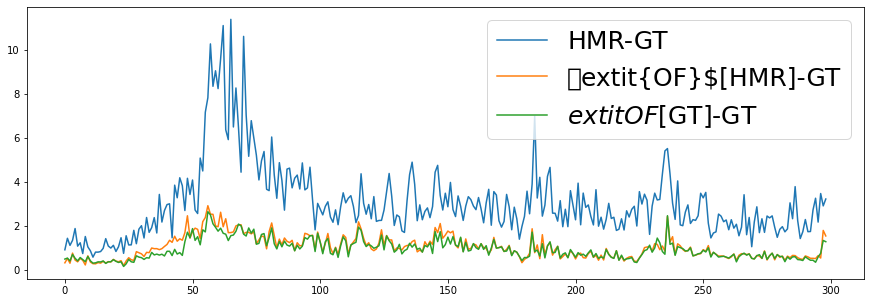

In [119]:
### LR
fig, ax = plt.subplots(1,1,figsize=(15,5))
hmr___gtLR = (flow_hmrLR.cpu() - flow_gtLR.cpu()).norm(dim=-1)
hmr___gtLR = (hmr___gtLR.cpu() * maskLR.cpu()).sum(dim=-1) / maskLR.cpu().sum(dim=-1)
of_hmr___gtLR = (flow_of_on_hmrLR.cpu() - flow_gtLR.cpu()).norm(dim=-1)
of_hmr___gtLR = (of_hmr___gtLR.cpu() * maskLR.cpu()).sum(dim=-1) / maskLR.cpu().sum(dim=-1)
ratiosLR = hmr___gtLR / of_hmr___gtLR

# hmr___gtHR = (flow_hmrHR.cpu() - flow_gtHR.cpu()).norm(dim=-1)
# hmr___gtHR = (hmr___gtHR.cpu() * maskHR.cpu()).sum(dim=-1) / maskHR.cpu().sum(dim=-1)
# of_hmr___gtHR = (flow_of_on_hmrHR.cpu() - flow_gtHR.cpu()).norm(dim=-1)
# of_hmr___gtHR = (of_hmr___gtHR.cpu() * maskHR.cpu()).sum(dim=-1) / maskHR.cpu().sum(dim=-1)
# ratiosHR = hmr___gtHR / of_hmr___gtHR

of_gt___gtLR = (flow_of_on_gtLR.cpu() - flow_gtLR.cpu()).norm(dim=-1)
of_gt___gtLR = (of_gt___gtLR.cpu() * maskLR.cpu()).sum(dim=-1) / maskLR.cpu().sum(dim=-1)

ax.plot(hmr___gtLR, label="HMR-GT")
ax.plot(of_hmr___gtLR, label="OF[HMR]-GT")
ax.plot(of_gt___gtLR, label="OF[GT]-GT")
ax.legend(fontsize=25)

In [121]:
d = {}
d["hmr__gt"] = hmr___gtLR.numpy()
d["of_hmr__gt"] = of_hmr___gtLR.numpy()
d["of_gt__gt"] = of_gt___gtLR.numpy()

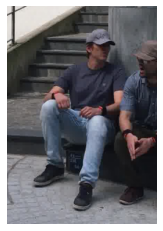

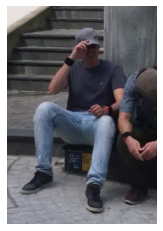

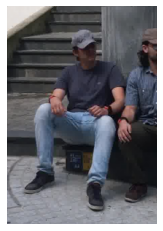

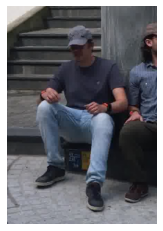

In [136]:

required_ids = [150, 200, 250, 299]
for idx in required_ids:
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    d = 100
    ax.imshow(UNNORMALIZE(sample['videoOF'])[idx].permute(1,2,0)[:,d:-d])
#     ax.set_title(idx)
    ax.set_axis_off()